In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
os.environ['TWITTER_TOKEN'] = ''

camara_base_url = 'https://dadosabertos.camara.leg.br/api/v2/'

# Dados Públicos Câmara dos Deputados

## Exercícios

1) Gráfico de pizza com o tamanho das bancadas de cada na câmara
2) Despesas dos deputados no ano de 2020
    - Subplot com gráfico de barras horizontais com o total de despesas por partido e 
    - Subplot com o valor médio de despesa por candidato para cada partido
3) Gráfico de barras horizontais com o total de despesas por categoria de todos os deputados
4) Histograma do valor médio gasto por cada deputado
5) Grafico em barras com os top 20 deputados com mais despesas
6) Identificar o deputado que mais reportou despesas tipo 'COMBUSTÍVEIS E LUBRIFICANTES.'
7) Qual é o deputado que menos gastou com 'DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.'?

In [2]:
url = f'{camara_base_url}/deputados'
response = requests.get(url)
if not response.ok: # != 200:
    raise Exception('Nao foi possivel recuperar os dados')

df_deputados = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
print(df_deputados.shape)
df_deputados.head()

(511, 9)


,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,Abilio Brunini,PL,https://dadosabertos.camara.leg.br/api/v2/part...,MT,57,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliobrunini@camara.leg.br
1,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
2,220714,https://dadosabertos.camara.leg.br/api/v2/depu...,Adail Filho,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,AM,57,https://www.camara.leg.br/internet/deputado/ba...,dep.adailfilho@camara.leg.br
3,221328,https://dadosabertos.camara.leg.br/api/v2/depu...,Adilson Barroso,PL,https://dadosabertos.camara.leg.br/api/v2/part...,SP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.adilsonbarroso@camara.leg.br
4,204560,https://dadosabertos.camara.leg.br/api/v2/depu...,Adolfo Viana,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,57,https://www.camara.leg.br/internet/deputado/ba...,dep.adolfoviana@camara.leg.br


## Bancadas de Partidos 

Text(0.5, 1.0, 'Tamanho da Bancada dos Partidos')

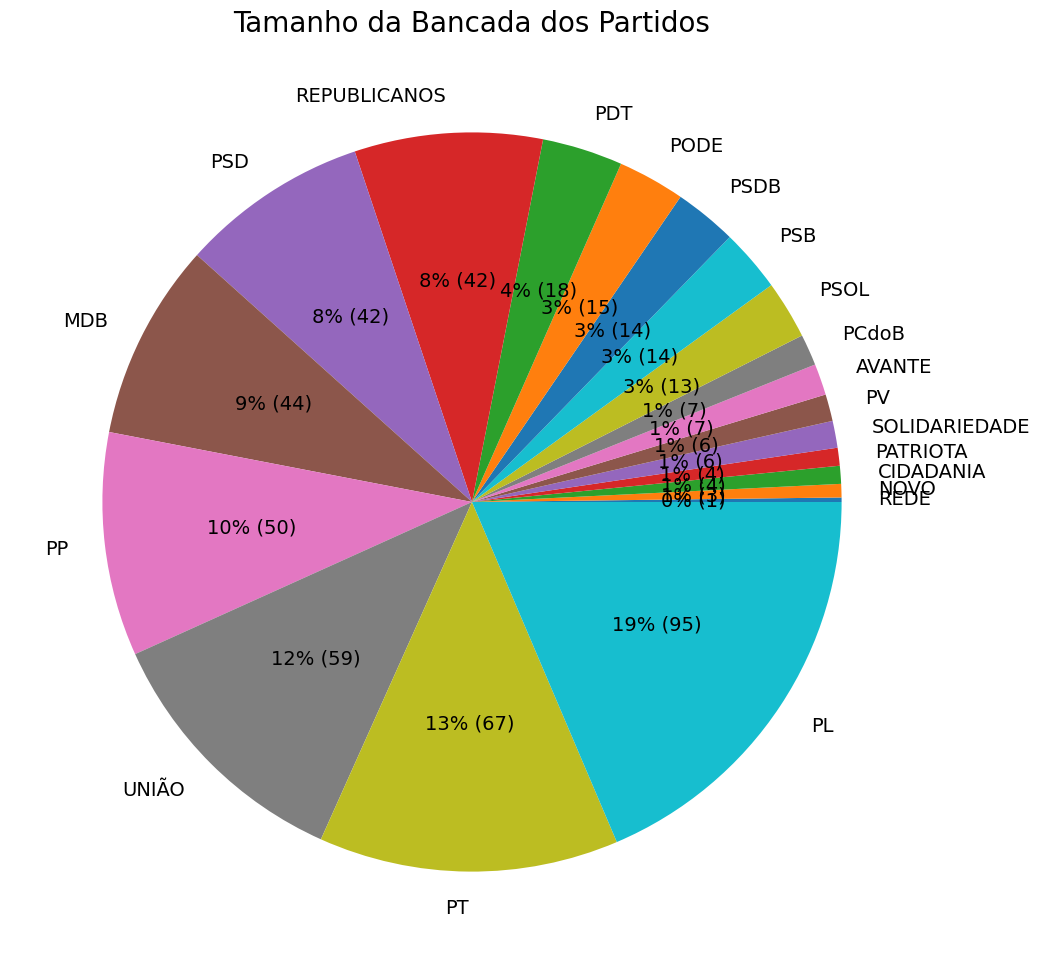

In [3]:
plt.figure(figsize=(12,12))

def autopct_label(x):
    return '{:.0f}% ({:.0f})'.format(x, total*x/100)

total = df_deputados.shape[0]

(df_deputados.groupby('siglaPartido')
             .nome
             .nunique()
             .sort_values()
             .plot(kind='pie', startangle=0, fontsize=14, autopct=autopct_label)
)
plt.ylabel('')
plt.title(f'Tamanho da Bancada dos Partidos', fontsize=20)


## Despesas dos Deputados

In [4]:
list_expenses = []
idLegislatura = '56', # depudatos eleitos em 2018,
anoDespesa = '2020'
maxItens = '100' # somente suporta ate 100

for id in tqdm(df_deputados.id.unique()):
    url = f'{camara_base_url}/deputados/{id}/despesas'
    params = {
        'idLegislatura': idLegislatura, 
        'ano': anoDespesa,
        'itens': maxItens,
    }
    # Execucao da primeira pagina de resultados.
    response = requests.get(url, params)
    df_resp = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
    df_resp['id'] = id
    list_expenses.append(df_resp)
    # Link para proxima pagina
    df_links = pd.DataFrame().from_dict(json.loads(response.text)['links'])
    df_links = df_links.set_index('rel').href
    
    while 'next' in df_links.index:
        response = requests.get(df_links['next'])
        df_resp = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
        df_resp['id'] = id
        list_expenses.append(df_resp)
        # Link para proxima pagina
        df_links = pd.DataFrame().from_dict(json.loads(response.text)['links'])
        df_links = df_links.set_index('rel').href
        
df_expenses = pd.concat(list_expenses)

# Merge para trazer as informacoes de sigla e afins do deputado
df_expenses = df_expenses.merge(df_deputados, on=['id'])
df_expenses.head()

100%|██████████| 511/511 [08:37<00:00,  1.01s/it]


,id,ano,mes,tipoDespesa,codDocumento,tipoDocumento,codTipoDocumento,dataDocumento,numDocumento,valorDocumento,...,codLote,parcela,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,204379,2020.0,2.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7018213.0,Nota Fiscal Eletrônica,4.0,2020-02-18,1790,145.00,...,1678271.0,0.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
1,204379,2020.0,6.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7065252.0,Nota Fiscal Eletrônica,4.0,2020-06-16,545,229.00,...,1702259.0,0.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
2,204379,2020.0,2.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7031733.0,Nota Fiscal,0.0,2020-03-03,417246,268.40,...,1684292.0,0.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
3,204379,2020.0,1.0,COMBUSTÍVEIS E LUBRIFICANTES.,6993481.0,Nota Fiscal Eletrônica,4.0,2020-01-06,479,3600.00,...,1666719.0,0.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
4,204379,2020.0,8.0,COMBUSTÍVEIS E LUBRIFICANTES.,7090596.0,Nota Fiscal Eletrônica,4.0,2020-08-03,128126,200.02,...,1715262.0,0.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AP,57,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br


# Informação Disponível de Despesas 

### Valor Liquido Total e Por Deputado 

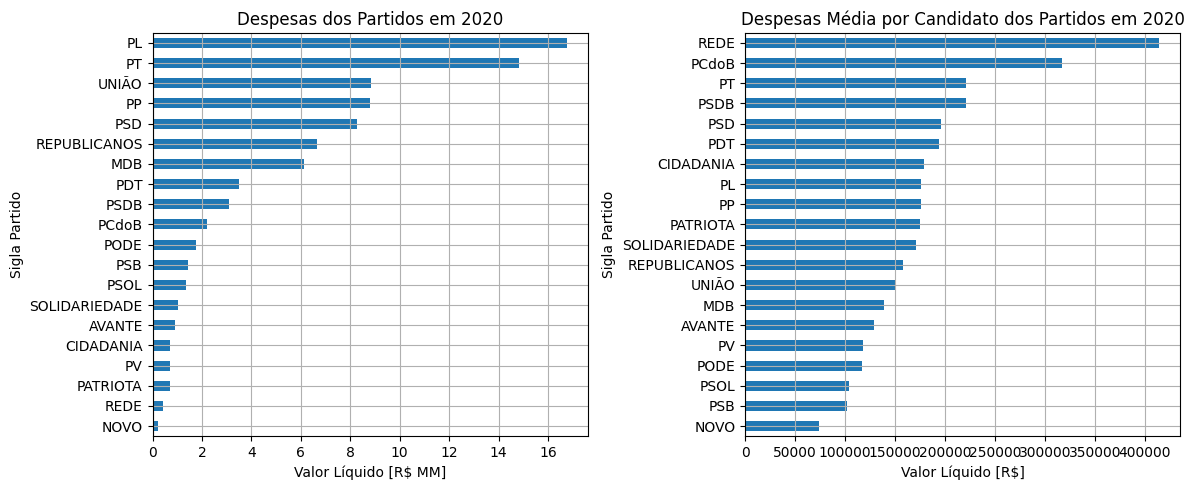

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
X =(df_expenses.groupby('siglaPartido')
            .valorLiquido
            .sum()
            .sort_values())
(X / 1e6).plot.barh()
plt.ylabel('Sigla Partido')
plt.xlabel('Valor Líquido [R$ MM]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Despesas dos Partidos em {expense_years}")

plt.subplot(1,2,2)
Xn = df_deputados.groupby('siglaPartido', as_index=False).nome.nunique()
Xn = Xn.merge(X.reset_index(), on='siglaPartido')
Xn['ValorMedioPorCandidato'] = Xn['valorLiquido'] / Xn['nome']
(Xn.set_index('siglaPartido')
   .sort_values('ValorMedioPorCandidato')
   .ValorMedioPorCandidato
   .plot
   .barh()
)
plt.ylabel('Sigla Partido')
plt.xlabel('Valor Líquido [R$]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Despesas Média por Candidato dos Partidos em {expense_years}")
plt.tight_layout()

In [6]:
df_expenses.tipoDespesa.unique()

array(['MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR',
       'COMBUSTÍVEIS E LUBRIFICANTES.',
       'CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.',
       'DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.', 'TELEFONIA',
       'SERVIÇOS POSTAIS',
       'LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES',
       'PASSAGEM AÉREA - SIGEPA', 'LOCAÇÃO OU FRETAMENTO DE AERONAVES',
       'PASSAGEM AÉREA - RPA',
       'HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.',
       'SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO',
       'PASSAGENS TERRESTRES, MARÍTIMAS OU FLUVIAIS',
       'PASSAGEM AÉREA - REEMBOLSO', 'ASSINATURA DE PUBLICAÇÕES',
       'FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR',
       'SERVIÇO DE SEGURANÇA PRESTADO POR EMPRESA ESPECIALIZADA.',
       'PARTICIPAÇÃO EM CURSO, PALESTRA OU EVENTO SIMILAR',
       'LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES'], dtype=object)

### Tipos de Despesas de Maior Valor 

Text(0.5, 1.0, 'Valor Líquido por Tipo de Despesa em 2020')

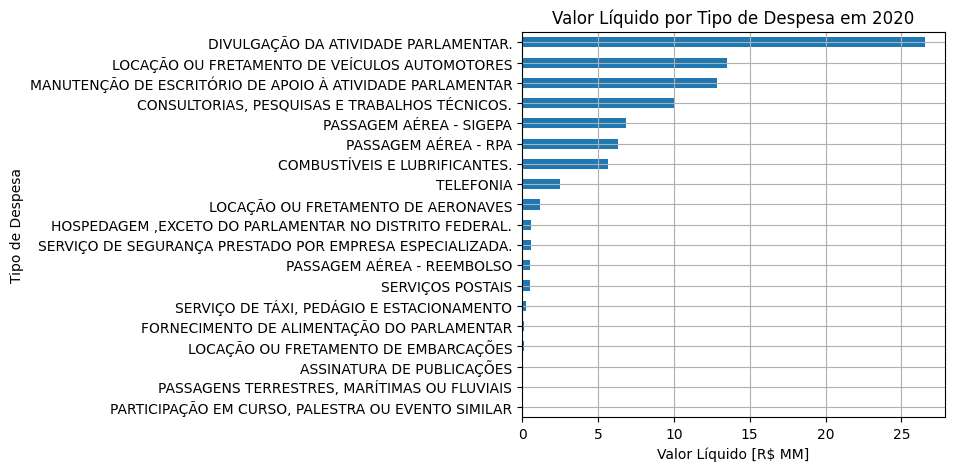

In [7]:
df_expenses.tipoDespesa.unique()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
X =(df_expenses.groupby('tipoDespesa')
            .valorLiquido
            .sum()
            .sort_values())
(X / 1e6).plot.barh()
plt.ylabel('Tipo de Despesa')
plt.xlabel('Valor Líquido [R$ MM]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Valor Líquido por Tipo de Despesa em {expense_years}")


# Recuperar Proposições Recentes

In [8]:
from datetime import datetime
from pandas.tseries.offsets import DateOffset

url = f'{camara_base_url}/proposicoes'

params = {
    'dataFim': str(datetime.today().date()),
    'dataInicio': str((datetime.today() - DateOffset(days=10)).date()),
}
# Execucao da primeira pagina de resultados.
response = requests.get(url, params)
response
df_proposicoes = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
print('Total de proposicoes:', df_proposicoes.shape[0])

Total de proposicoes: 15


# OpenAI - IA Gerativa

In [9]:

from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
import dotenv

dotenv.load_dotenv()

sys_msg = SystemMessage(content="""Voce é um advogado experiente, com atuação na formulação de leis
e discussões públicas sobre direito constitucional. Sumarize as proposições votadas na câmara dos
deputados que o usuário apresentar. As proposições serão passadas no formato:
### PROPOSIÇÃO ###
<proposição>
###
"""
)

gpt_model = 'gpt-4-1106-preview' #"gpt-3.5-turbo-0613" # 'gpt-4-1106-preview'

chat = ChatOpenAI(temperature=0.8, model=gpt_model, max_tokens = df_proposicoes.ementa.str.len().max())

def ia_summarize(group):
    # Formulacao do texto de entrada do usuario
    msg = f"""
    ### PROPOSIÇÃO ###
    {group.ementa}
    ###
    """
    human_msg = HumanMessage(content=msg)
    print(human_msg)
    answer = chat([human_msg])
    df_ia = pd.Series(data=[answer.content], name='proposicao_ia').to_frame()
    return df_ia
    # return answer.content

# Aplicando nas 2 primeiras proposicoes somente
df_ia_proposicoes = df_proposicoes.iloc[:2].groupby('id').apply(ia_summarize).reset_index().drop('level_1',axis=1)
df_ia_proposicoes.head()

content='\n    ### PROPOSIÇÃO ###\n    0    Altera os arts 3º e 9º da Lei nº 7.802, de 11 ...\nName: ementa, dtype: object\n    ###\n    '
content='\n    ### PROPOSIÇÃO ###\n    1    Dispõe sobre a reintegração no emprego dos fun...\nName: ementa, dtype: object\n    ###\n    '


,id,proposicao_ia
0,46249,Parece que você está apresentando o início de ...
1,307689,Parece que você está tentando me mostrar uma e...


In [10]:
df_proposicoes.ementa.values[0]

'Altera os arts 3º e 9º da Lei nº 7.802, de 11 de julho de 1989, que dispõe sobre a pesquisa, a experimentação, a produção, a embalagem e rotulagem, o transporte, o armazenamento, a comercialização, a propaganda comercial, a utilização, a importação, a exportação, o destino final dos resíduos e embalagens, o registro, a classificação, o controle, a inspeção e a fiscalização de agrotóxicos, seus componentes e afins, e dá outras providências.  NOVA EMENTA: Dispõe sobre a pesquisa, a experimentação, a produção, a embalagem e a rotulagem, o transporte, o armazenamento, a comercialização, a utilização, a importação, a exportação, o destino final dos resíduos e das embalagens, o registro, a classificação, o controle, a inspeção e a fiscalização de pesticidas, de produtos de controle ambiental e afins; altera a Lei Delegada nº 8, de 11 de outubro de 1962; revoga as Leis nºs 7.802, de 11 de julho de 1989, e 9.974, de 6 de junho de 2000, partes de anexos das Leis nºs 6.938, de 31 de agosto de 1

In [11]:
df_ia_proposicoes.proposicao_ia.values[0]

'Parece que você está apresentando o início de uma ementa de uma proposta legislativa que visa alterar os artigos 3º e 9º da Lei nº 7.802, de 11 de julho de 1989, também conhecida como a Lei dos Agrotóxicos no Brasil. A ementa é um resumo que indica a finalidade da proposição legislativa.\n\nPara oferecer mais informações ou uma análise mais detalhada, seria necessário ter o texto completo da proposição, bem como detalhes sobre o conteúdo específico das alterações propostas. Se você tiver mais informações ou questões relacionadas a essa proposição, sinta-se à vontade para compartilhá-las.'